In [1]:
import networkx as nx #pip install networkx
from itertools import combinations
from datetime import datetime
from time import time
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords  #pip install nltk
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
from nltk.stem.porter import PorterStemmer
import string
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from gensim.models import word2vec  #pip install word2vec
from wordcloud import WordCloud  #pip install wordcloud
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import NMF, LatentDirichletAllocation
from textblob import TextBlob  #Sentiment Analysis - pip install textblob
from sklearn.decomposition import TruncatedSVD, NMF
import matplotlib.patches as mpatches
import matplotlib
path_to_csv = '../../../cs82_advanced_machine_learning_data/HW2/papers.csv'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khan_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.style

from matplotlib.colors import ListedColormap

dark2_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
dark2_cmap = ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (10, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 12
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

import seaborn as sns 
current_palette = sns.color_palette("Set2")

mpl.style.use('seaborn')  

In [3]:
df_allPlays = pd.read_csv('Shakespeare_data.csv')
print(df_allPlays.shape)
df_allPlays.head()

(111396, 6)


Dataline      Play  PlayerLinenumber ActSceneLine         Player  \
0         1  Henry IV               NaN          NaN            NaN   
1         2  Henry IV               NaN          NaN            NaN   
2         3  Henry IV               NaN          NaN            NaN   
3         4  Henry IV               1.0        1.1.1  KING HENRY IV   
4         5  Henry IV               1.0        1.1.2  KING HENRY IV   

                                          PlayerLine  
0                                              ACT I  
1                       SCENE I. London. The palace.  
2  Enter KING HENRY, LORD JOHN OF LANCASTER, the ...  
3             So shaken as we are, so wan with care,  
4         Find we a time for frighted peace to pant,

In [4]:
df_allPlays.isna().sum()

Dataline               0
Play                   0
PlayerLinenumber       3
ActSceneLine        6243
Player                 7
PlayerLine             0
dtype: int64

In [5]:
df_allPlays[df_allPlays.isnull().any(axis=1)].head()

Dataline      Play  PlayerLinenumber ActSceneLine        Player  \
0           1  Henry IV               NaN          NaN           NaN   
1           2  Henry IV               NaN          NaN           NaN   
2           3  Henry IV               NaN          NaN           NaN   
111       112  Henry IV              10.0          NaN  WESTMORELAND   
112       113  Henry IV              10.0          NaN  WESTMORELAND   

                                            PlayerLine  
0                                                ACT I  
1                         SCENE I. London. The palace.  
2    Enter KING HENRY, LORD JOHN OF LANCASTER, the ...  
111                                             Exeunt  
112    SCENE II. London. An apartment of the Prince's.

In [6]:
df_allPlays.ActSceneLine.isnull().groupby([df_allPlays['Play']]).sum()

Play
A Comedy of Errors           88.0
A Midsummer nights dream    138.0
A Winters Tale              125.0
Alls well that ends well    158.0
Antony and Cleopatra        297.0
As you like it              145.0
Coriolanus                  224.0
Cymbeline                   201.0
Hamlet                      224.0
Henry IV                    161.0
Henry V                     162.0
Henry VI Part 1             206.0
Henry VI Part 2             204.0
Henry VI Part 3             199.0
Henry VIII                  140.0
Julius Caesar               174.0
King John                   117.0
King Lear                   266.0
Loves Labours Lost          108.0
Measure for measure         158.0
Merchant of Venice          137.0
Merry Wives of Windsor      217.0
Much Ado about nothing      120.0
Othello                     199.0
Pericles                    169.0
Richard II                  137.0
Richard III                 236.0
Romeo and Juliet            217.0
Taming of the Shrew         169.0
The Tempe

Name: 
Type: Graph
Number of nodes: 971
Number of edges: 1328
Average degree:   2.7353


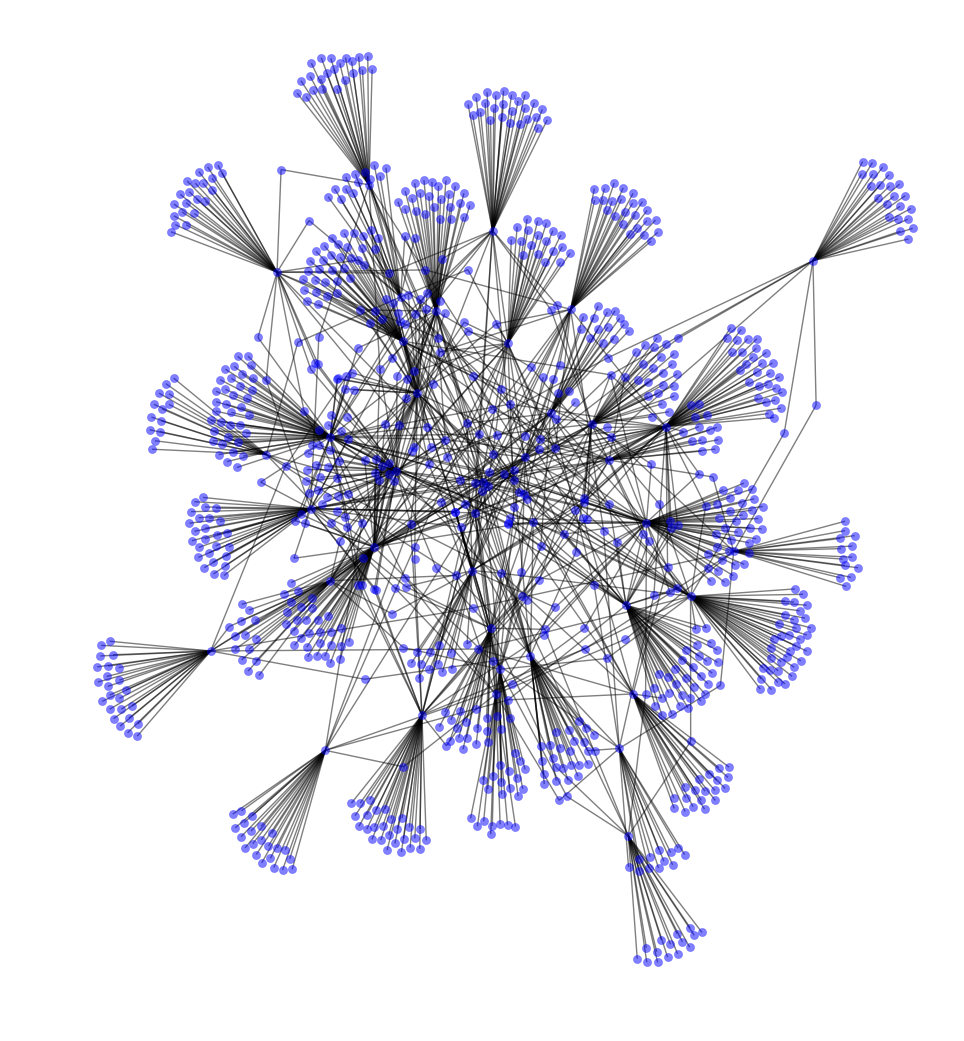

In [7]:
Graphx= nx.Graph()
Graphx = nx.from_pandas_edgelist(df_allPlays,source='Play',target='Player')
print (nx.info(Graphx))
plt.figure(figsize=(9,10)) 
nx.draw(Graphx,alpha=0.5, node_color="blue",with_labels=False,node_size=35)
plt.show()

In [59]:
class RemoveAllNans (TransformerMixin, BaseEstimator):
    def __init__(self, prints = False):
        self.prints = prints
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X.dropna()
    
    
class split_act_scene_line (TransformerMixin, BaseEstimator):
    def __init__(self, prints = False):
        self.prints = prints
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        X[['Act','Scene','Line']] = X['ActSceneLine'].str.split('.', expand=True).apply(pd.to_numeric)
        return X
    
class group_data(TransformerMixin, BaseEstimator):
    def __init__(self, grouping = "Act",  prints = False):
        self.prints = prints
        self.grouping = grouping
        print(self.grouping)
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        if self.grouping == "Play" : 
                group_by = ["Play"]
        elif self.grouping == "Act" : 
                group_by = ["Play", "Act"]
        elif self.grouping == "Scene":
                group_by = ["Play", "Act", "Scene"] 
        lines = X.groupby(group_by)["PlayerLine"].sum().reset_index()["PlayerLine"]
        f = lambda x : list(combinations(x.values,2))
        players = X.groupby(group_by)["Player"].apply(f).reset_index()
        #players = X.groupby(group_by)["Player"].unique().reset_index()
        X_new = pd.concat([players, lines], axis=1)
        X_new = X_new.rename(columns={'Player': 'Players'})
        return X_new
    
class alphanumeric_lowercase(TransformerMixin, BaseEstimator):
    def __init__(self, prints = False):
        self.prints = prints
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        #Lower Case
        #X.loc[:,'Player'] = X.Player.apply(lambda x : [s.lower() for s in x])
        X.loc[:,'PlayerLine'] = X.PlayerLine.apply(lambda x: x.lower())
        #Alphanumeric
        regex = re.compile(r'\W+')
        #X.loc[:,'Player'] = X.Player.apply(lambda x: regex.sub(' ', x))
        X.loc[:,'PlayerLine'] = X.PlayerLine.apply(lambda x: regex.sub(' ', x))
        return X
    

In [60]:
GROUPING = "Scene"  # Change to "Play", "Act" or "Scene" to change what each row should represent

allplays_pipeline = Pipeline([
    ('romove_na', RemoveAllNans()),
    ('split_act_scene_line', split_act_scene_line()),
    ('group_data', group_data(grouping=GROUPING)),
    ('alphanumeric', alphanumeric_lowercase())
])

df_PlayData = allplays_pipeline.fit_transform(df_allPlays)

#df_PlayData['Player'][0]
df_PlayData.head(50)

Scene


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Play  Act  Scene  \
0         A Comedy of Errors    1      1   
1         A Comedy of Errors    1      2   
2         A Comedy of Errors    2      1   
3         A Comedy of Errors    2      2   
4         A Comedy of Errors    3      1   
5         A Comedy of Errors    3      2   
6         A Comedy of Errors    4      1   
7         A Comedy of Errors    4      2   
8         A Comedy of Errors    4      3   
9         A Comedy of Errors    4      4   
10        A Comedy of Errors    5      1   
11  A Midsummer nights dream    1      1   
12  A Midsummer nights dream    1      2   
13  A Midsummer nights dream    2      1   
14  A Midsummer nights dream    2      2   
15  A Midsummer nights dream    3      1   
16  A Midsummer nights dream    3      2   
17  A Midsummer nights dream    4      1   
18  A Midsummer nights dream    4      2   
19  A Midsummer nights dream    5      1   
20            A Winters Tale    1      1   
21            A Winters Tale    1      2   
22            A Winters Tale    2      1   
23            A Winters Tale    2      2   
24            A Winters Tale    2      3   
25            A Winters Tale    3      1   
26            A Winters Tale    3      2   
27            A Winters Tale    3      3   
28            A Winters Tale    4      2   
29            A Winters Tale    4      3   
30            A Winters Tale    4      4   
31            A Winters Tale    5      1   
32            A Winters Tale    5      2   
33            A Winters Tale    5      3   
34  Alls well that ends well    1      1   
35  Alls well that ends well    1      2   
36  Alls well that ends well    1      3   
37  Alls well that ends well    2      1   
38  Alls well that ends well    2      2   
39  Alls well that ends well    2      3   
40  Alls well that ends well    2      4   
41  Alls well that ends well    2      5   
42  Alls well that ends well    3      1   
43  Alls well that ends well    3      2   
44  Alls well that ends well    3      3   
45  Alls well that ends well    3      4   
46  Alls well that ends well    3      5   
47  Alls well that ends well    3      6   
48  Alls well that ends well    3      7   
49  Alls well that ends well    4      1   

                                              Players  \
0   [(AEGEON, AEGEON), (AEGEON, DUKE SOLINUS), (AE...   
1   [(First Merchant, First Merchant), (First Merc...   
2   [(ADRIANA, ADRIANA), (ADRIANA, ADRIANA), (ADRI...   
3   [(LUCIANA, OF SYRACUSE), (LUCIANA, OF SYRACUSE...   
4   [(LUCIANA, OF EPHESUS), (LUCIANA, OF EPHESUS),...   
5   [(LUCIANA, LUCIANA), (LUCIANA, LUCIANA), (LUCI...   
6   [(Second Merchant, Second Merchant), (Second M...   
7   [(ADRIANA, ADRIANA), (ADRIANA, ADRIANA), (ADRI...   
8   [(ADRIANA, OF SYRACUSE), (ADRIANA, OF SYRACUSE...   
9   [(Courtezan, OF EPHESUS), (Courtezan, OF EPHES...   
10  [(ANGELO, ANGELO), (ANGELO, ANGELO), (ANGELO, ...   
11  [(THESEUS, THESEUS), (THESEUS, THESEUS), (THES...   
12  [(QUINCE, BOTTOM), (QUINCE, BOTTOM), (QUINCE, ...   
13  [(PUCK, Fairy), (PUCK, Fairy), (PUCK, Fairy), ...   
14  [(TITANIA, TITANIA), (TITANIA, TITANIA), (TITA...   
15  [(BOTTOM, QUINCE), (BOTTOM, QUINCE), (BOTTOM, ...   
16  [(OBERON, OBERON), (OBERON, OBERON), (OBERON, ...   
17  [(PUCK, PUCK), (PUCK, TITANIA), (PUCK, TITANIA...   
18  [(QUINCE, STARVELING), (QUINCE, STARVELING), (...   
19  [(HIPPOLYTA, HIPPOLYTA), (HIPPOLYTA, THESEUS),...   
20  [(ARCHIDAMUS, ARCHIDAMUS), (ARCHIDAMUS, ARCHID...   
21  [(POLIXENES, POLIXENES), (POLIXENES, POLIXENES...   
22  [(HERMIONE, HERMIONE), (HERMIONE, First Lady),...   
23  [(PAULINA, PAULINA), (PAULINA, PAULINA), (PAUL...   
24  [(LEONTES, LEONTES), (LEONTES, LEONTES), (LEON...   
25  [(CLEOMENES, CLEOMENES), (CLEOMENES, CLEOMENES...   
26  [(LEONTES, LEONTES), (LEONTES, LEONTES), (LEON...   
27  [(ANTIGONUS, ANTIGONUS), (ANTIGONUS, Mariner),...   
28  [(POLIXENES, POLIXENES), (POLIXENES, POLIXENES...   
29  [(Shepherd, Time), (Shepherd, Time), (Shepherd...   
30  [(FLORIZ

In [62]:
print(df_PlayData.isna().sum())
print(df_PlayData.dtypes)
print(df_PlayData.shape)
print(df_PlayData['Players'][1])

Play          0
Act           0
Scene         0
Players       0
PlayerLine    0
dtype: int64
Play          object
Act            int64
Scene          int64
Players       object
PlayerLine    object
dtype: object
(737, 5)
[('First Merchant', 'First Merchant'), ('First Merchant', 'First Merchant'), ('First Merchant', 'First Merchant'), ('First Merchant', 'First Merchant'), ('First Merchant', 'First Merchant'), ('First Merchant', 'First Merchant'), ('First Merchant', 'First Merchant'), ('First Merchant', 'First Merchant'), ('First Merchant', 'OF SYRACUSE'), ('First Merchant', 'OF SYRACUSE'), ('First Merchant', 'OF SYRACUSE'), ('First Merchant', 'OF SYRACUSE'), ('First Merchant', 'OF SYRACUSE'), ('First Merchant', 'OF SYRACUSE'), ('First Merchant', 'OF SYRACUSE'), ('First Merchant', 'OF SYRACUSE'), ('First Merchant', 'DROMIO OF SYRACUSE'), ('First Merchant', 'DROMIO OF SYRACUSE'), ('First Merchant', 'DROMIO OF SYRACUSE'), ('First Merchant', 'OF SYRACUSE'), ('First Merchant', 'OF SYRACUSE')

In [104]:
func = lambda x : pd.DataFrame(x, columns = ['player1', 'player2'])

df_Players = df_PlayData.groupby(['Play','Act'])["Players"].sum().reset_index()
df_Players = df_PlayData.groupby(['Play'])["Players"].sum().reset_index()
print(df_Players.shape)
df_Players.head()

(36, 2)


Play                                            Players
0        A Comedy of Errors  [(AEGEON, AEGEON), (AEGEON, DUKE SOLINUS), (AE...
1  A Midsummer nights dream  [(THESEUS, THESEUS), (THESEUS, THESEUS), (THES...
2            A Winters Tale  [(ARCHIDAMUS, ARCHIDAMUS), (ARCHIDAMUS, ARCHID...
3  Alls well that ends well  [(COUNTESS, BERTRAM), (COUNTESS, BERTRAM), (CO...
4      Antony and Cleopatra  [(PHILO, PHILO), (PHILO, PHILO), (PHILO, PHILO...

In [144]:
def plot_network (Play, Players):
    pairs = pd.DataFrame(Players, columns = ['player1', 'player2'])
    g = nx.from_pandas_edgelist(pairs,source='player1',target='player2')
    plt.figure(figsize=(25,25))
    options = {
        'edge_color': '#555555',
        'width': 1,
        'with_labels': True, 
        'node_color': '#FFDEA2',
        'font_weight': 'bold',
        'font_size':16
    }
    
    title_options = {
        'fontweight': 'bold',
        'fontsize': 20
    }
    nx.draw_networkx(g,   pos=nx.spring_layout(g, k=0.5, iterations=50), **options)
    #nx.draw(g, **options)
    #nx.draw_spring(g, **options)
    ax = plt.gca()
    ax.set_axis_off()
    ax.set_title(Play, **title_options)
    plt.show()

## Plot a few plays to make sure the character network looks good.

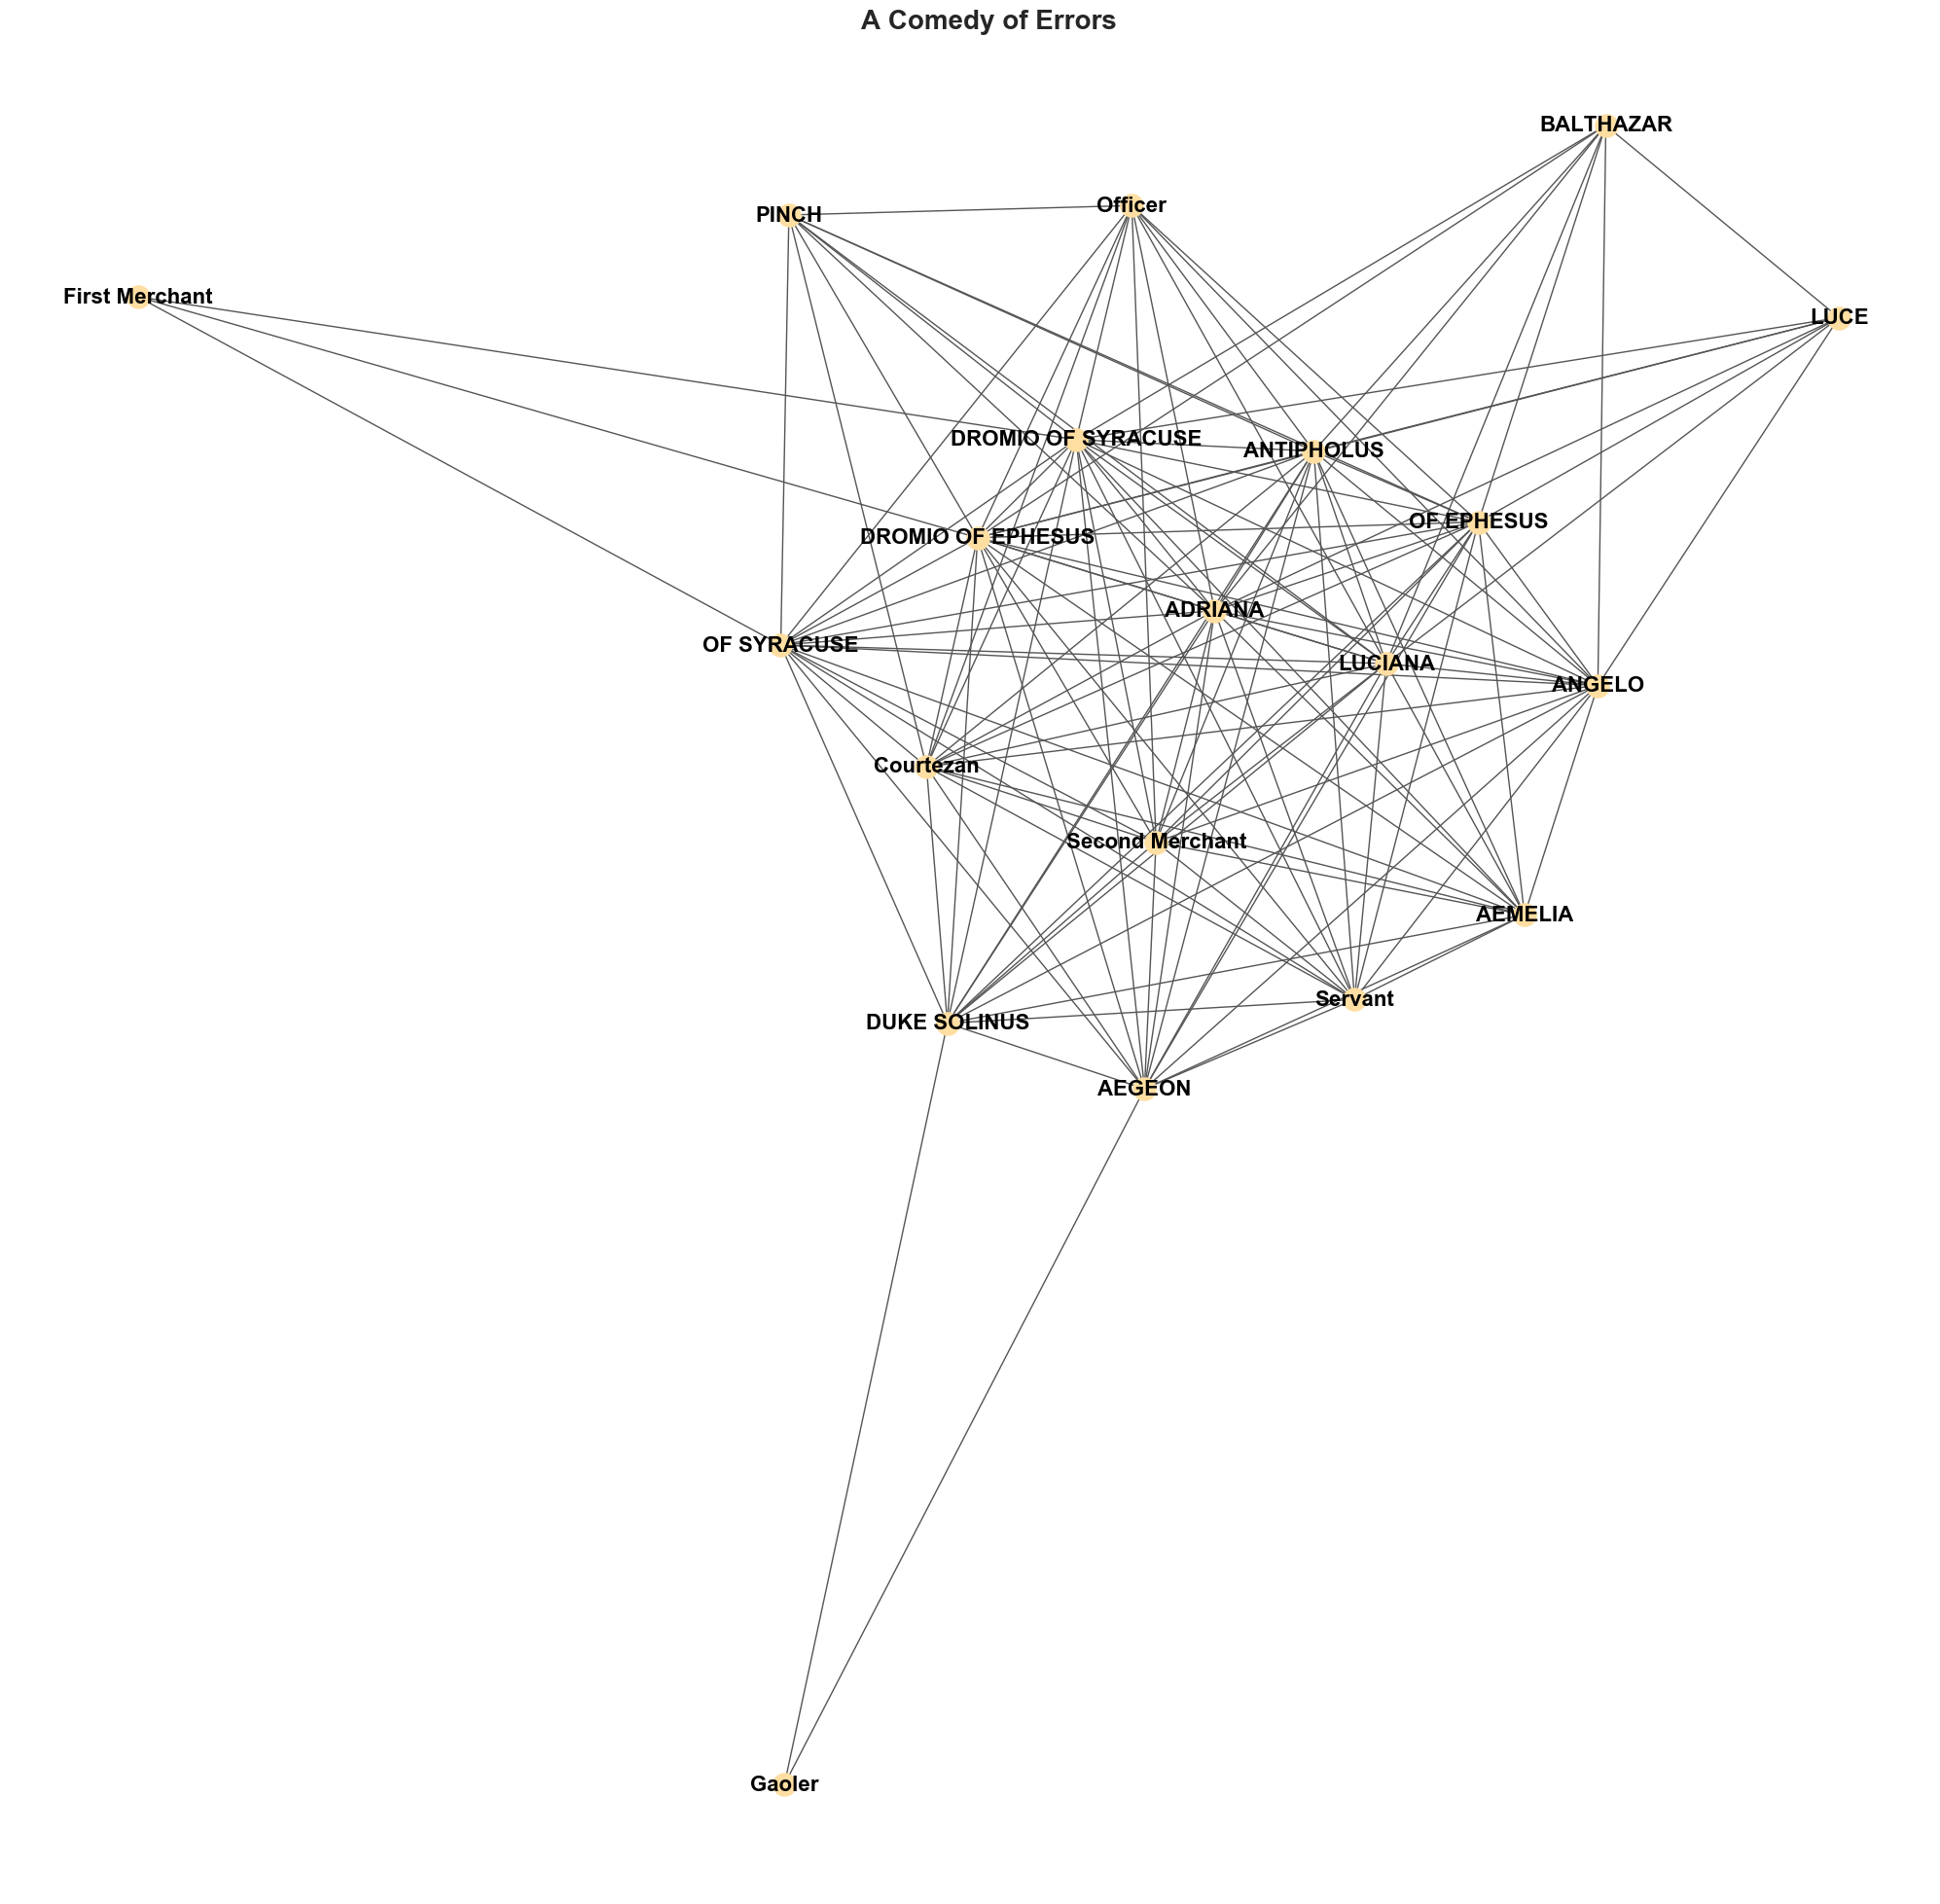

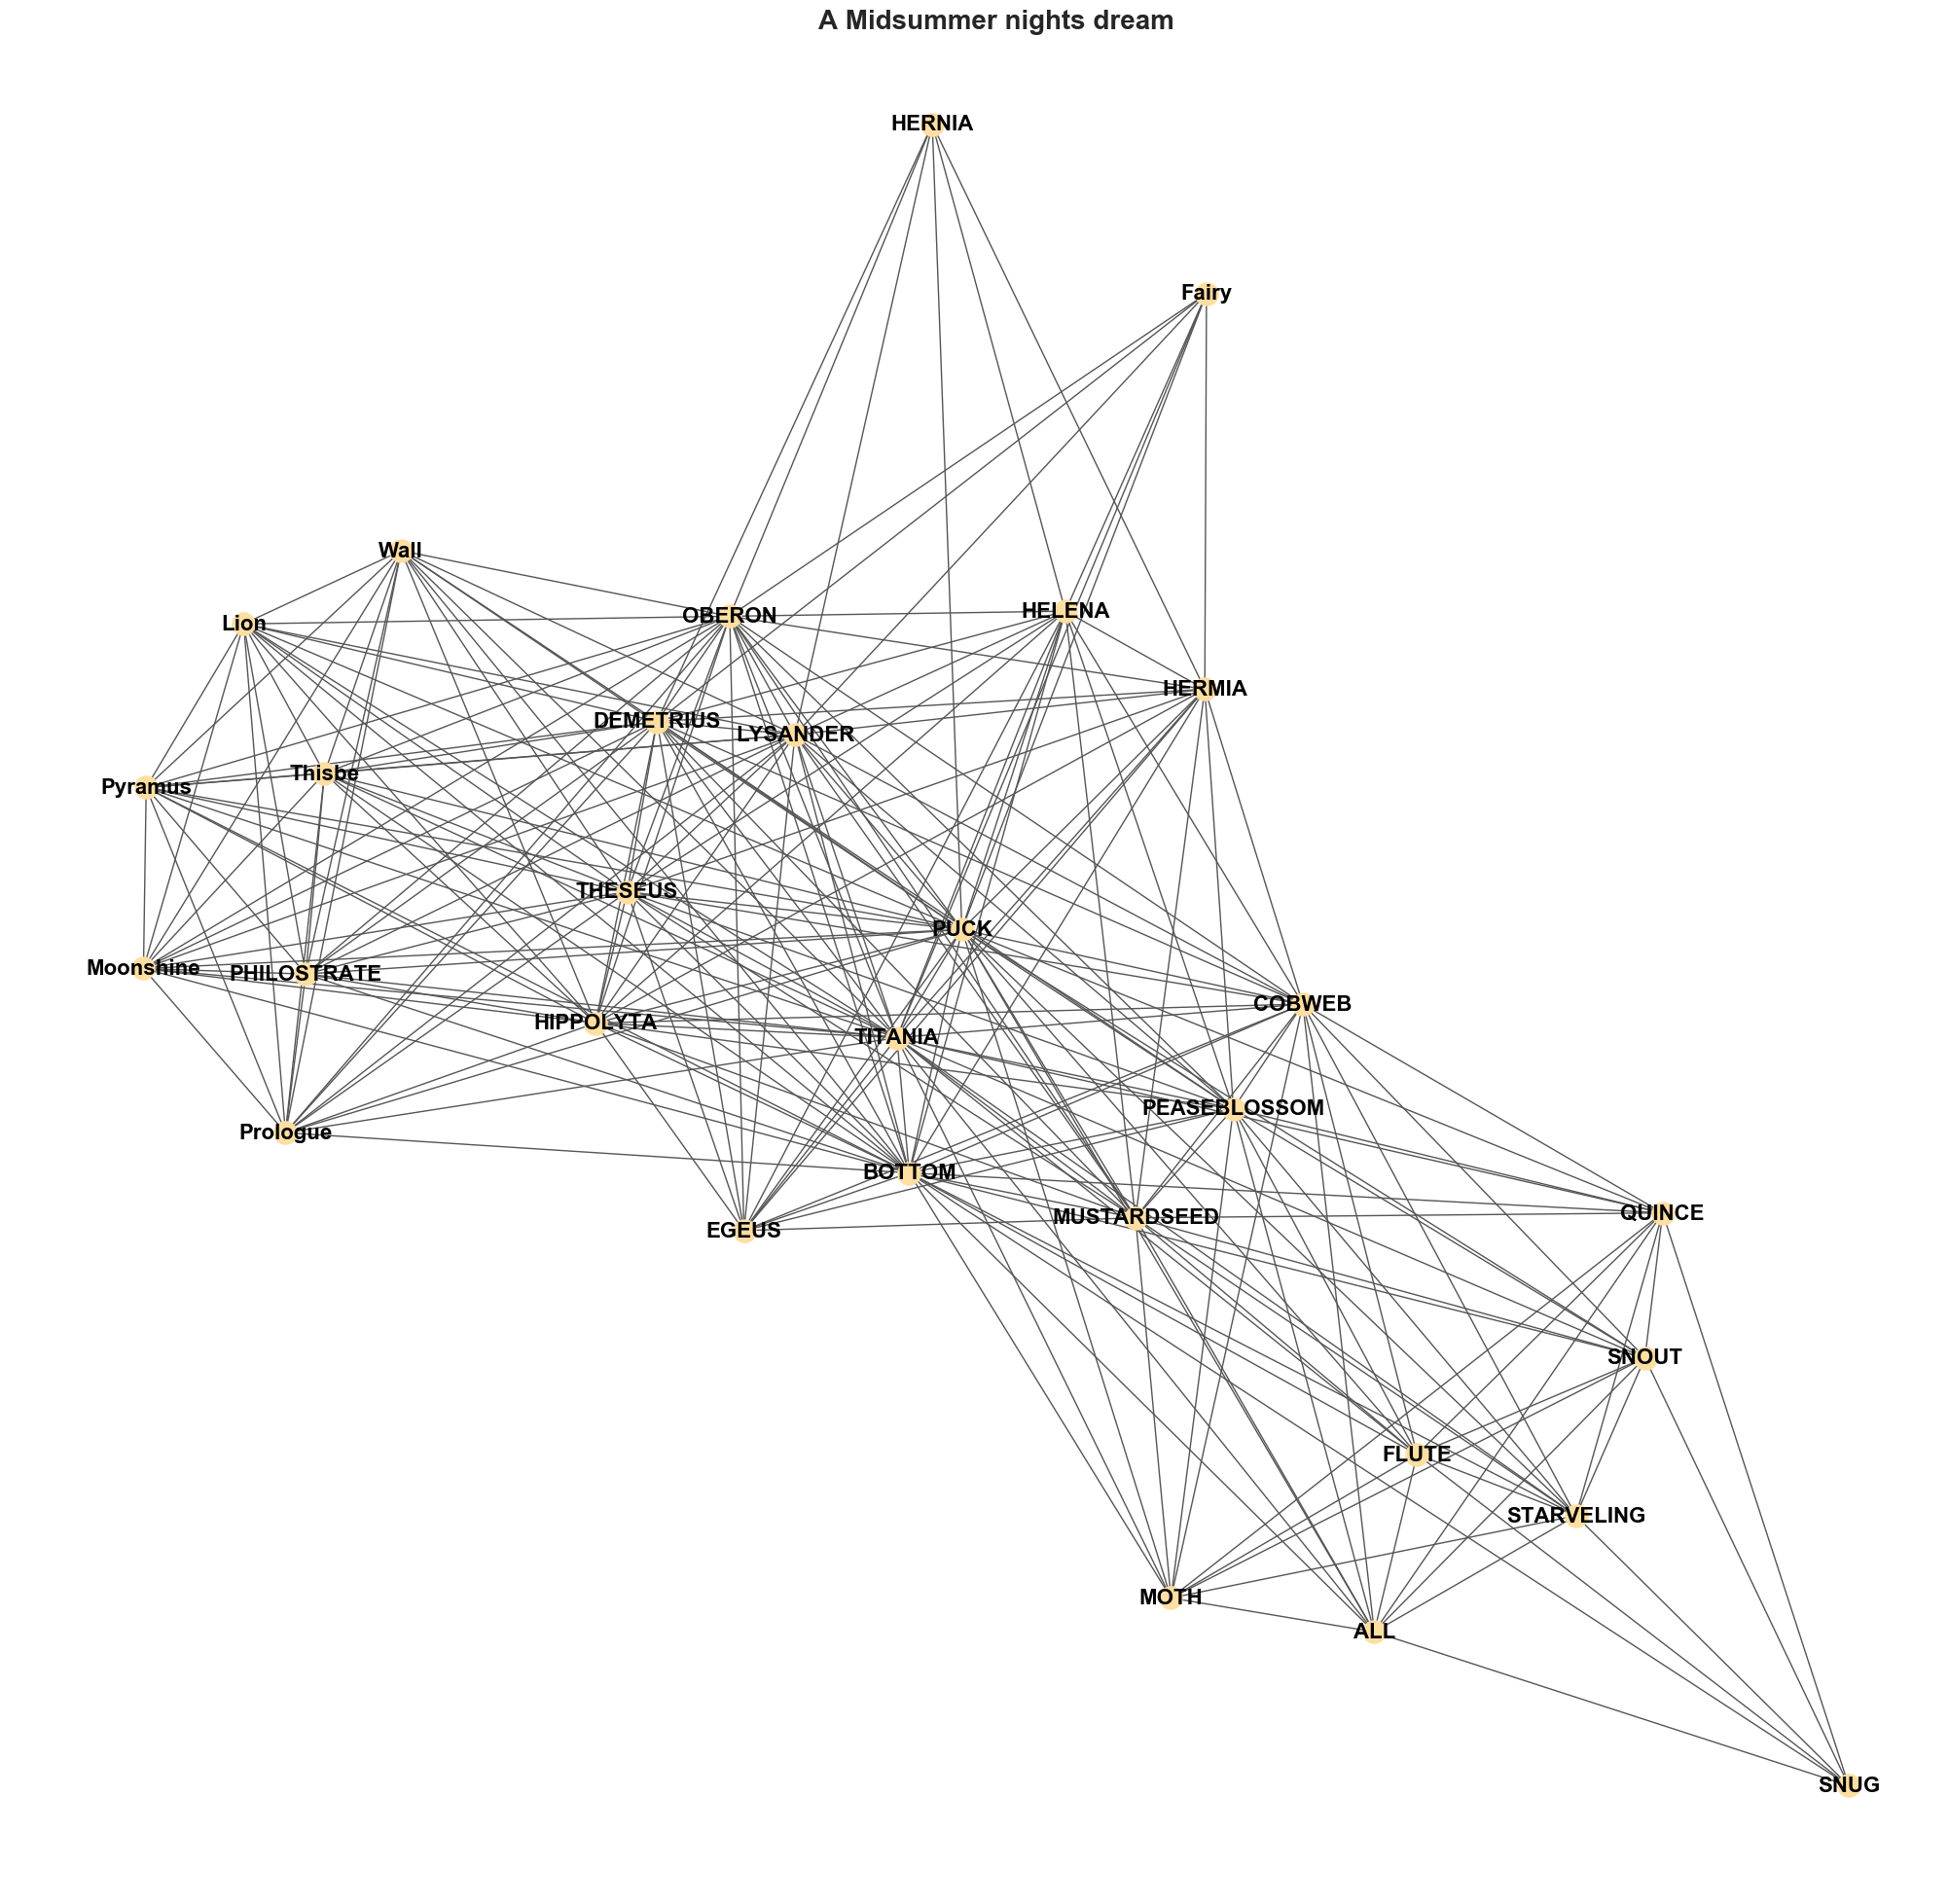

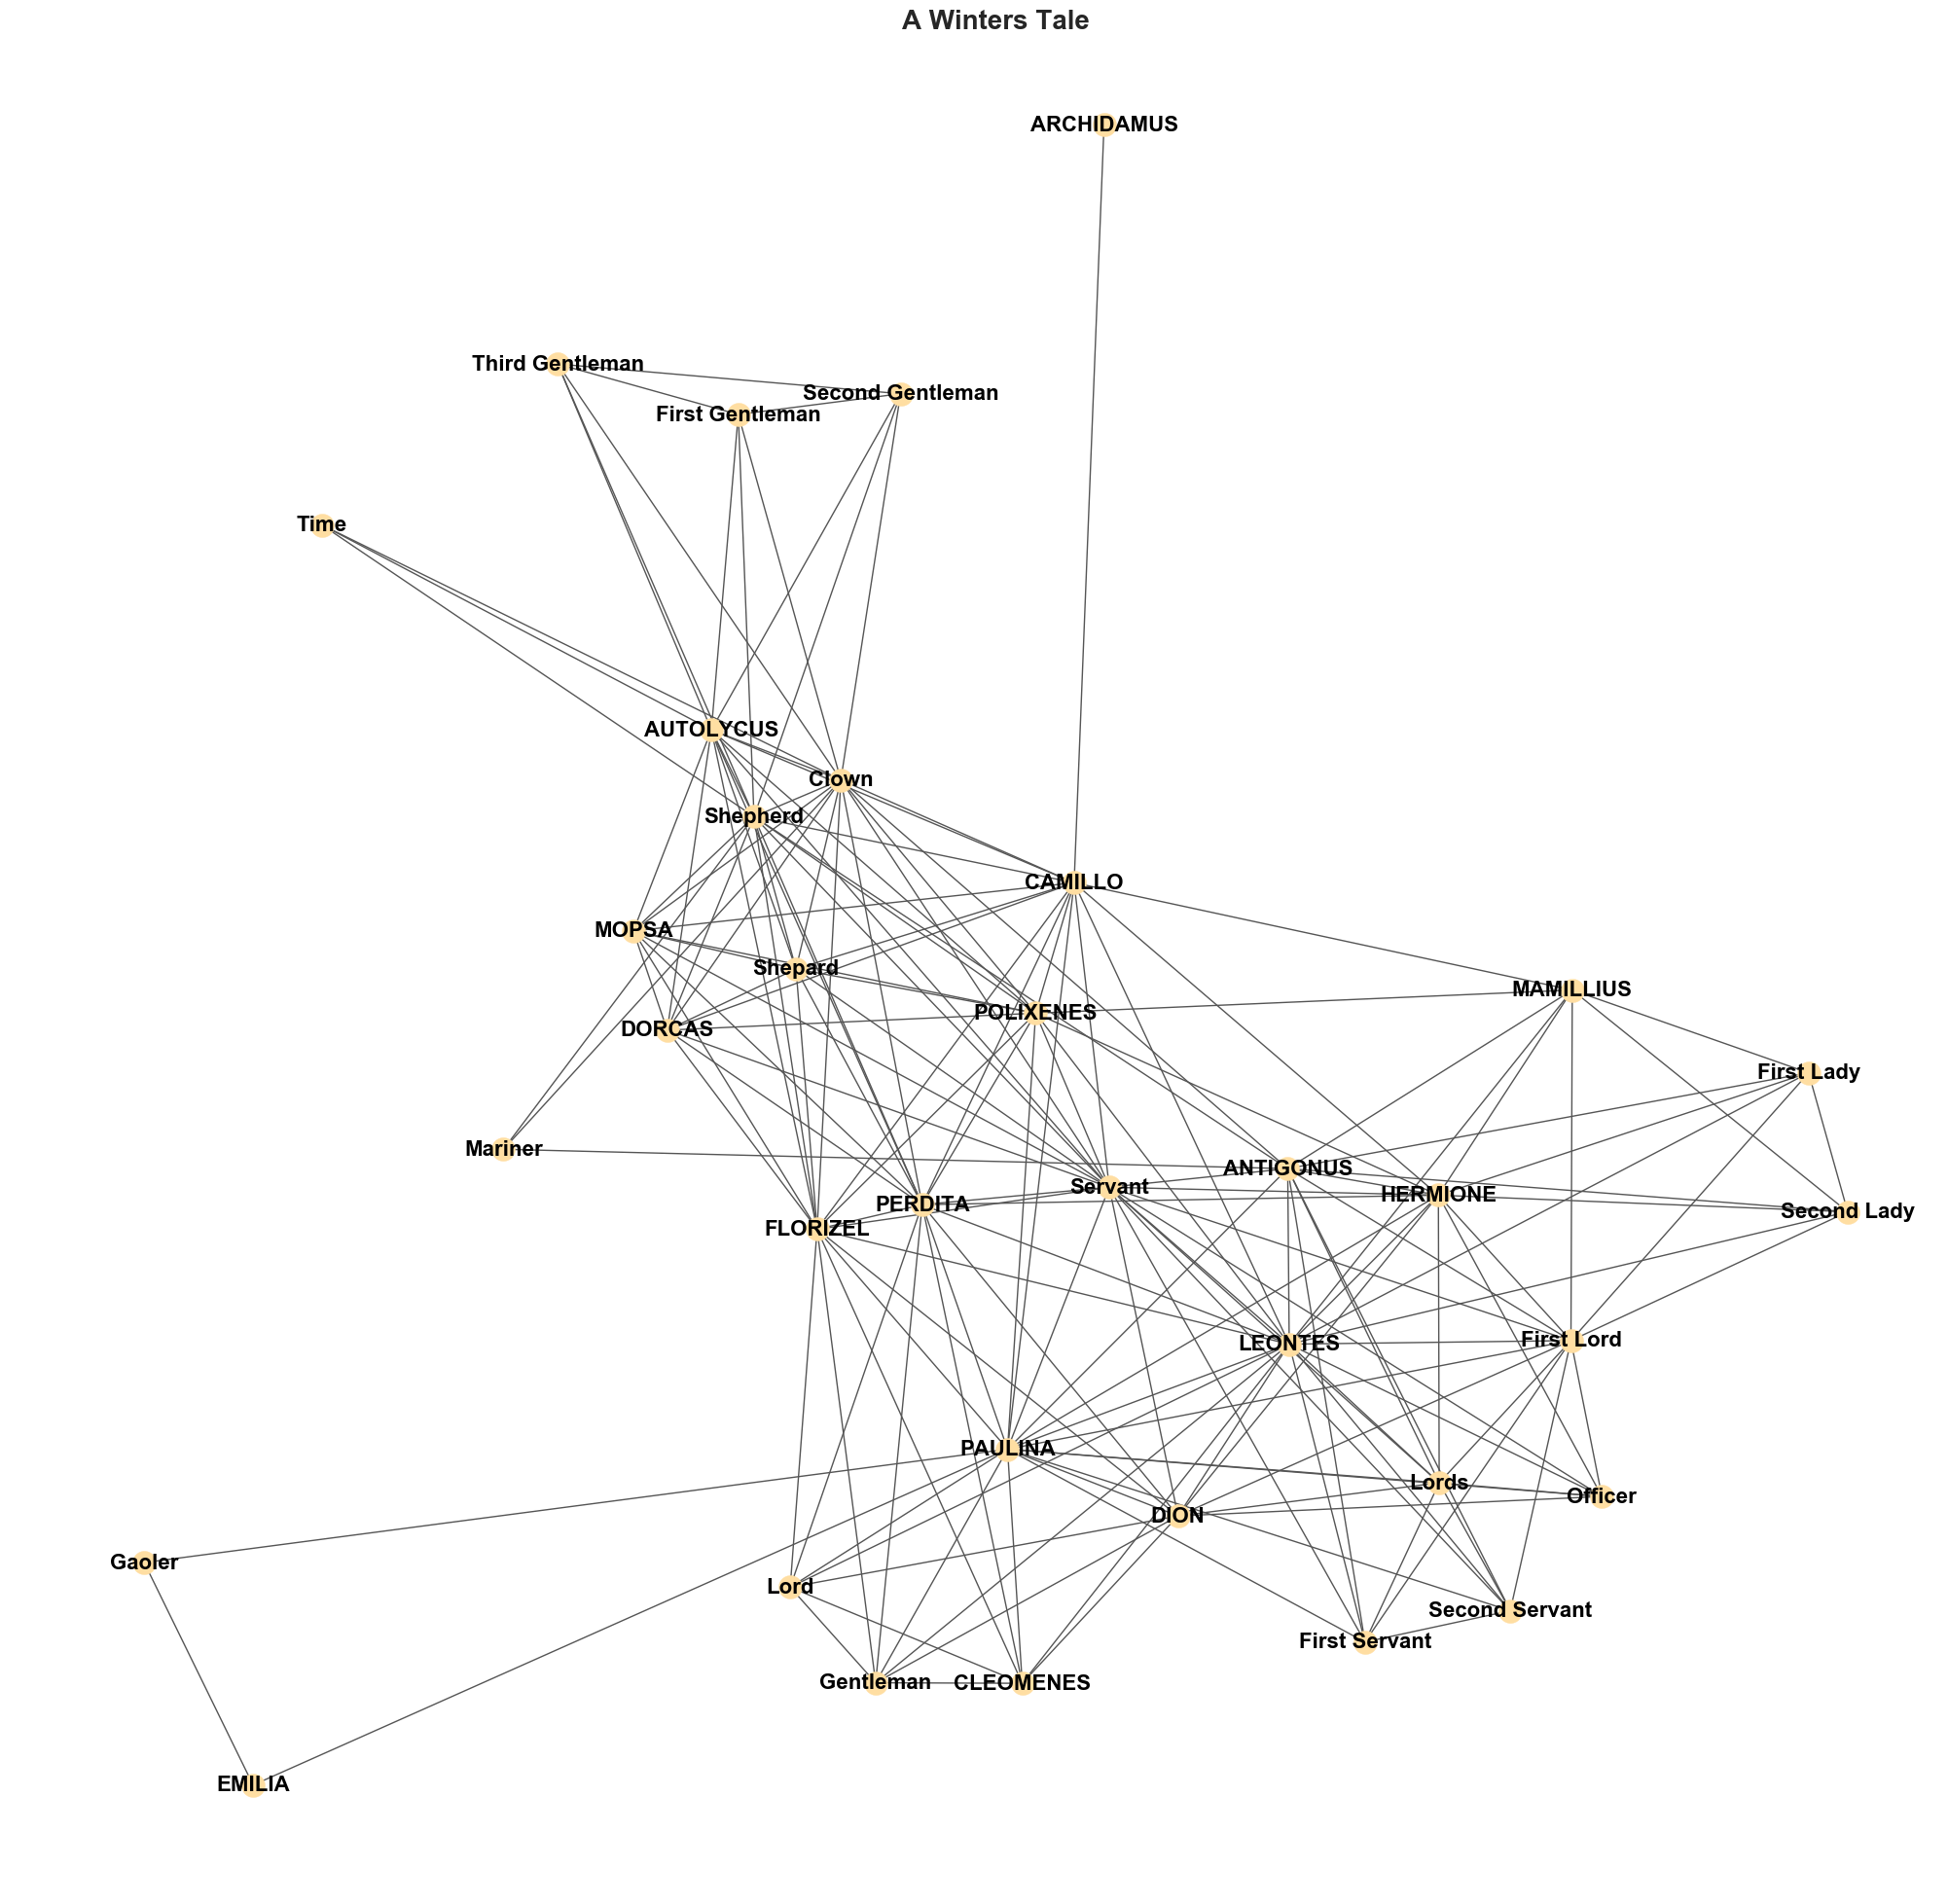

In [149]:
# PLOT A FEW OF THE PLAYS TO MAKE SURE EVERYTHING LOOKS GOOD
row, column = df_Players.shape
for i in range(3):
    plot_network(df_Players['Play'][i], df_Players['Players'][i])

## Create Pandas Frame with Centrality Measures

In [146]:
centralMeasures = pd.DataFrame(nx.degree_centrality(g),index=[0]).T
centralMeasures.columns=['Degree Centrality']
centralMeasures['Closeness centrality']= pd.DataFrame(nx.closeness_centrality(g),index=[0]).T
centralMeasures['Betweenness centrality']= pd.DataFrame(nx.betweenness_centrality(g),index=[0]).T
centralMeasures['Eigenvector centrality']= pd.DataFrame(nx.eigenvector_centrality(g),index=[0]).T
centralMeasures['Page Rank']= pd.DataFrame(nx.pagerank(g),index=[0]).T
centralMeasures['Name']= centralMeasures.index.tolist()
centralMeasures.index = np.arange(0,len(centralMeasures))
centralMeasures.sort_values(by=['Degree Centrality'], ascending=False).head(15)

Degree Centrality  Closeness centrality  Betweenness centrality  \
5            1.052632              0.950000                0.058004   
6            1.052632              0.950000                0.058004   
7            1.000000              0.904762                0.024865   
8            1.000000              0.904762                0.024865   
9            1.000000              0.904762                0.024865   
12           1.000000              0.904762                0.024865   
13           0.947368              0.863636                0.017962   
4            0.947368              0.863636                0.035169   
16           0.894737              0.826087                0.007878   
0            0.842105              0.791667                0.049708   
1            0.842105              0.791667                0.049708   
14           0.842105              0.791667                0.002924   
18           0.789474              0.760000                0.000000   
19           0.789474              0.760000                0.000000   
15           0.684211              0.678571                0.001300   

    Eigenvector centrality  Page Rank                Name  
5                 0.271714   0.066412  DROMIO OF SYRACUSE  
6                 0.271714   0.066412   DROMIO OF EPHESUS  
7                 0.268173   0.061976             ADRIANA  
8                 0.268173   0.061976             LUCIANA  
9                 0.268173   0.061976          OF EPHESUS  
12                0.268173   0.061976          ANTIPHOLUS  
13                0.257909   0.058804              ANGELO  
4                 0.253839   0.059871         OF SYRACUSE  
16                0.250298   0.055435           Courtezan  
0                 0.229608   0.055040              AEGEON  
1                 0.229608   0.055040        DUKE SOLINUS  
14                0.240034   0.052263     Second Merchant  
18                0.227701   0.049202             AEMELIA  
19                0.227701   0.049202             Servant  
15                0.191349   0.043223             Officer

In [243]:
def calculate_centralities(df_Players): 
    row, column = df_Players.shape
    lst_return = []
    for i in range(row):
        pairs = pd.DataFrame(df_Players['Players'][i], columns = ['player1', 'player2'])
        g = nx.from_pandas_edgelist(pairs,source='player1',target='player2')
        centralMeasures = pd.DataFrame(nx.degree_centrality(g),index=[0]).T
        centralMeasures.columns=['Degree Centrality']
        centralMeasures['Closeness centrality']= pd.DataFrame(nx.closeness_centrality(g),index=[0]).T
        centralMeasures['Betweenness centrality']= pd.DataFrame(nx.betweenness_centrality(g),index=[0]).T
        centralMeasures['Eigenvector centrality']= pd.DataFrame(nx.eigenvector_centrality(g),index=[0]).T
        centralMeasures['Page Rank']= pd.DataFrame(nx.pagerank(g),index=[0]).T
        #centralMeasures['Name']= centralMeasures.index.tolist()
        centralMeasures.index = np.arange(0,len(centralMeasures))

        
        means = centralMeasures.mean()
        lst_return.append({'Play':df_Players['Play'][i], 'Degree Centrality': means[0], 'Closeness centrality': means[1],
                           'Betweenness Centrality': means[2], 'Eigenvector centrality': means[3], 'Page Rank': means[4],
                          })

        print(df_Players['Play'][i])
        print(centralMeasures.shape)
        #df_return = pd.concat(df_return, centralMeasures)
        #print(centralMeasures.sort_values(by=['Degree Centrality'], ascending=False).head(15))
    return pd.DataFrame(lst_return)
df_centralities= calculate_centralities(df_Players)


A Comedy of Errors
(20, 5)
A Midsummer nights dream
(30, 5)
A Winters Tale
(35, 5)
Alls well that ends well
(25, 5)
Antony and Cleopatra
(54, 5)
As you like it
(27, 5)
Coriolanus
(61, 5)
Cymbeline
(40, 5)
Hamlet
(34, 5)
Henry IV
(35, 5)
Henry V
(47, 5)
Henry VI Part 1
(52, 5)
Henry VI Part 2
(65, 5)
Henry VI Part 3
(46, 5)
Henry VIII
(47, 5)
Julius Caesar
(50, 5)
King John
(29, 5)
King Lear
(26, 5)
Loves Labours Lost
(20, 5)
Measure for measure
(25, 5)
Merchant of Venice
(23, 5)
Merry Wives of Windsor
(24, 5)
Much Ado about nothing
(24, 5)
Othello
(28, 5)
Pericles
(48, 5)
Richard II
(36, 5)
Richard III
(70, 5)
Romeo and Juliet
(37, 5)
Taming of the Shrew
(37, 5)
The Tempest
(20, 5)
Timon of Athens
(55, 5)
Titus Andronicus
(27, 5)
Troilus and Cressida
(29, 5)
Twelfth Night
(18, 5)
Two Gentlemen of Verona
(17, 5)
macbeth
(41, 5)


In [244]:
df_centralities.head(36)

Betweenness Centrality  Closeness centrality  Degree Centrality  \
0                 0.019006              0.774816           0.784211   
1                 0.016338              0.700980           0.611494   
2                 0.027960              0.535484           0.351261   
3                 0.029130              0.615134           0.446667   
4                 0.015871              0.501565           0.252271   
5                 0.032251              0.568305           0.387464   
6                 0.013763              0.512764           0.261749   
7                 0.017308              0.495779           0.314103   
8                 0.020889              0.618478           0.426025   
9                 0.028571              0.446468           0.307563   
10                0.025326              0.481382           0.252544   
11                0.019563              0.518713           0.273756   
12                0.015736              0.470175           0.234615   
13                0.021673              0.530114           0.303382   
14                0.024648              0.459137           0.236818   
15                0.013759              0.488336           0.274286   
16                0.024539              0.620803           0.463054   
17                0.021795              0.674652           0.575385   
18                0.014035              0.817673           0.852632   
19                0.029710              0.611267           0.446667   
20                0.027480              0.657658           0.553360   
21                0.015481              0.766123           0.735507   
22                0.024704              0.665819           0.590580   
23                0.018213              0.631617           0.523810   
24                0.022105              0.475036           0.203901   
25                0.027218              0.536530           0.331746   
26                0.013196              0.454391           0.224845   
27                0.016173              0.560432           0.408408   
28                0.023423              0.562989           0.384384   
29                0.022807              0.730767           0.731579   
30                0.017165              0.537891           0.268013   
31                0.020855              0.678136           0.584046   
32                0.021620              0.588477           0.458128   
33                0.021242              0.768517           0.777778   
34                0.046569              0.610598           0.522059   
35                0.023577              0.533640           0.276829   

    Eigenvector centrality  Page Rank                      Play  
0                 0.212264   0.050000        A Comedy of Errors  
1                 0.172734   0.033333  A Midsummer nights dream  
2                 0.148645   0.028571            A Winters Tale  
3                 0.179749   0.040000  Alls well that ends well  
4                 0.113984   0.018519      Antony and Cleopatra  
5                 0.167720   0.037037            As you like it  
6                 0.103375   0.016393                Coriolanus  
7                 0.130989   0.025000                 Cymbeline  
8                 0.151378   0.029412                    Hamlet  
9                 0.136009   0.028571                  Henry IV  
10                0.121499   0.021277                   Henry V  
11                0.117509   0.019231           Henry VI Part 1  
12                0.096887   0.015385           Henry VI Part 2  
13                0.122785   0.021739           Henry VI Part 3  
14                0.115043   0.021277                Henry VIII  
15                0.118095   0.020000             Julius Caesar  
16                0.163708   0.034483                 King John  
17                0.182045   0.038462                 King Lear  
18                0.216015   0.050000        Loves Labours Lost  
19                0.180352   0.040000       Measure for 

In [245]:
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
# fit the model
clf = IsolationForest(max_samples=100, random_state=rng, contamination=0.1) 
#max_samples = The number of samples to draw from X to train each base estimator.
#contamination = The amount of contamination of the data set, i.e. the proportion
#of outliers in the data set.


clf.fit(df_centralities.drop("Play", axis=1))
y_pred_train = clf.predict(df_centralities.drop("Play",axis=1))
ind = np.argwhere(y_pred_train==-1)
print(ind)
print(y_pred_train)

for p in ind:
 print(df_centralities['Play'][p].values)


[[18]
 [26]
 [33]
 [34]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1 -1 -1  1]
['Loves Labours Lost']
['Richard III']
['Twelfth Night']
['Two Gentlemen of Verona']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:251: UserWarning: max_samples (100) is greater than the total number of samples (36). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


# TFIDF

In [216]:
# PARAMETERS FOR TFIDF
min_ngram = 2
max_ngram = 2

max_df = 0.90
min_df = 2
max_features = 10

vectorizer = TfidfVectorizer(ngram_range=(min_ngram, max_ngram), max_features = max_features, max_df = max_df)
X = vectorizer.fit_transform(df_PlayData["PlayerLine"])
print(X.get_shape())

(737, 10)


In [217]:
# CONVERT TFIDF RESULTS TO PANDAS DATA FRAME
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

# ADD THE YEAR COLUMN TO THE DATAFRAME
df_tfidf['Play'] = df_PlayData['Play']
df_tfidf.head(1000)

and the    in the     it is   my lord     of my    of the  the king  \
0    0.000000  0.388307  0.000000  0.151742  0.647168  0.395812  0.000000   
1    0.000000  0.318431  0.000000  0.000000  0.398032  0.324586  0.000000   
2    0.423058  0.000000  0.376028  0.000000  0.430917  0.702806  0.000000   
3    0.389549  0.634868  0.519366  0.000000  0.198393  0.000000  0.000000   
4    0.422540  0.688636  0.000000  0.000000  0.000000  0.175487  0.000000   
5    0.166684  0.679135  0.296309  0.000000  0.000000  0.138452  0.000000   
6    0.169386  0.690141  0.000000  0.000000  0.172532  0.140696  0.000000   
7    0.000000  0.675775  0.737108  0.000000  0.000000  0.000000  0.000000   
8    0.000000  0.549494  0.000000  0.000000  0.343428  0.280057  0.000000   
9    0.360382  0.000000  0.320319  0.000000  0.000000  0.000000  0.000000   
10   0.174367  0.568352  0.309967  0.166575  0.266410  0.072417  0.000000   
11   0.000000  0.475138  0.259130  0.278511  0.296956  0.000000  0.000000   
12   0.416772  0.679236  0.370441  0.000000  0.000000  0.346182  0.000000   
13   0.418599  0.795914  0.062011  0.066649  0.142125  0.347699  0.086058   
14   0.000000  0.519461  0.283303  0.000000  0.324658  0.529501  0.000000   
15   0.511075  0.416462  0.227130  0.000000  0.260285  0.636768  0.000000   
16   0.495040  0.268931  0.293339  0.000000  0.000000  0.274129  0.000000   
17   0.184134  0.300092  0.245496  0.703620  0.375109  0.305893  0.000000   
18   0.747430  0.000000  0.664340  0.000000  0.000000  0.000000  0.000000   
19   0.453953  0.462394  0.554796  0.433666  0.057798  0.141399  0.000000   
20   0.000000  0.621829  0.226088  0.000000  0.259091  0.211283  0.627530   
21   0.127893  0.000000  0.265243  0.773791  0.217115  0.141642  0.157759   
22   0.100533  0.327689  0.089357  0.864366  0.000000  0.083506  0.000000   
23   0.000000  0.000000  0.000000  0.000000  0.000000  0.383319  0.569247   
24   0.000000  0.000000  0.413719  0.622526  0.284466  0.386626  0.000000   
25   0.535742  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
26   0.205261  0.083631  0.182443  0.294133  0.522687  0.170496  0.506388   
27   0.000000  0.410938  0.448234  0.481758  0.000000  0.418880  0.000000   
28   0.000000  0.000000  0.525731  0.000000  0.602473  0.000000  0.000000   
29   0.159530  0.779984  0.141796  0.000000  0.162494  0.530039  0.196783   
..        ...       ...       ...       ...       ...       ...       ...   
707  0.000000  0.000000  0.000000  0.000000  0.000000  0.725455  0.000000   
708  0.000000  0.000000  0.321109  0.517688  0.551973  0.000000  0.000000   
709  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
710  0.000000  0.000000  0.000000  0.000000  0.000000  0.475504  0.706147   
711  0.433230  0.353029  0.192535  0.000000  0.000000  0.179926  0.534398   
712  0.278162  0.226667  0.741718  0.000000  0.566659  0.000000  0.000000   
713  0.000000  0.474916  0.518018  0.000000  0.395757  0.161365  0.479270   
714  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
715  0.656043  0.000000  0.000000  0.000000  0.334116  0.544927  0.000000   
716  0.000000  0.000000  0.738134  0.000000  0.281960  0.459864  0.341460   
717  0.922946  0.000000  0.000000  0.000000  0.000000  0.255541  0.000000   
718  0.175434  0.428870  0.311862  0.000000  0.178693  0.145720  0.432801   
719  0.000000  0.000000  0.000000  0.000000  0.000000  0.493535  0.732923   
720  0.000000  0.403850  0.264302  0.568139  0.201922  0.164662  0.000000   
721  0.258907  0.000000  0.000000  0.494672  0.000000  0.430109  0.319366   
722  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
723  0.224508  0.000000  0.000000  0.643423  0.000000  0.186482  0.000000   
724  0.598339  0.000000  0.000000  0.000000  0.000000  0.496996  0.000000   
725  0.512543  0.417659  0.000000  0.000000  0.000000  0.000000  0.632232   
726  0.000000  0.580436  0.000000  0.510351  0.544150  0.000000  0.000000   
72

In [218]:

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_tfidf.drop('Play', axis=1))
print ( kmeans.cluster_centers_)



[[0.11339157 0.24294959 0.12180905 0.08092537 0.12407876 0.14471762
  0.0233532  0.13063915 0.71218521 0.08180581]
 [0.14067417 0.24405132 0.125792   0.15664363 0.11319175 0.22596592
  0.63305958 0.15401781 0.26194378 0.08437854]
 [0.17670147 0.28190521 0.2542499  0.06474563 0.15235015 0.27973737
  0.01976337 0.20600372 0.12840963 0.19578868]
 [0.10299183 0.19024344 0.15748214 0.72214302 0.13215956 0.16326057
  0.08553881 0.13555982 0.19124389 0.1212847 ]]
